### Import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import pickle
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, log_loss
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU
import json
import gc

np.random.seed(2020)
random_state = 52
CATEGORIES = ["c0","c1","c2","c3","c4","c5","c6","c7","c8","c9"]
PATH_COLAB = "/content/drive/My Drive/Deep Learning Project/progetto/"

TensorFlow 1.x selected.


Using TensorFlow backend.


### Definition of functions

In [0]:
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def preprocessing(X, Y, img_rows, img_cols, color_type=3):
    
    Y = np.array(Y, dtype=np.uint8)

    if color_type == 1:
        X = np.array(X, dtype=np.uint8).reshape(-1, img_rows, img_cols, 1)
    else:
        X = np.array(X, dtype=np.uint8).reshape(-1, img_rows, img_cols, 3)

    Y = to_categorical(Y, 10)
    X = X.astype('float32')
    X /= 255
    
    return X, Y

In [0]:
def fine_tuning_vgg16(img_rows, img_cols, color_type, vgg_conv_base, final_layer):

    for layer in vgg_conv_base.layers[:-(final_layer)]:
        layer.trainable = False

    model = Sequential()
    # Add the vgg convolutional base model
    model.add(vgg_conv_base)

    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(10, activation = 'softmax'))

    model.summary()

    model.compile(optimizer = "SGD", loss='categorical_crossentropy', metrics = ["accuracy"])

    return model

In [0]:
def training_model(img_rows, img_cols, color_type=3, final_layer=8):
    
    df = pd.DataFrame(columns=['k', 'accuracy', 'log_loss', 'architecture'])
    batch_size = 32
    epochs = 20
    sum_score_acc = 0
    sum_score_log_loss = 0

    name_model = 'vgg16_'+str(final_layer)

    for k in range(1,6):

        print("\n\nFold " + str(k) + ' out of 5')

        X_train, Y_train, X_val, Y_val = restore_data(PATH_COLAB + "data/k_" + str(k) + ".dat")
        X_train, Y_train = preprocessing(X_train, Y_train, img_rows, img_cols, color_type)
        X_val, Y_val = preprocessing(X_val, Y_val, img_rows, img_cols, color_type)

        datagen = ImageDataGenerator(
          height_shift_range=0.5, 
          width_shift_range = 0.5, 
          zoom_range = 0.5, 
          rotation_range=20 
        )

        data_generator = datagen.flow(X_train, Y_train, batch_size = 32)

        vgg_conv = VGG16(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, color_type))
        model = fine_tuning_vgg16(img_rows, img_cols, color_type, vgg_conv, final_layer = final_layer)

        kfold_weights_path = os.path.join(PATH_COLAB + 'architecture/'+ name_model, 'weights_kfold_' + str(k) + '.h5')

        if not os.path.isfile(kfold_weights_path) or RESTORE_WEIGHTS == False:
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)
            ]
            class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=Y_train)
            
            history = model.fit_generator(data_generator, steps_per_epoch = len(X_train) // batch_size, 
                                epochs=epochs, shuffle=True, verbose=0, validation_data=(X_val, Y_val),
                                class_weight=class_weights, callbacks=callbacks)
            
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

            acc = history.history['acc']
            val_acc = history.history['val_acc']
            n_epoch = range(len(acc))
            axes[0].plot(n_epoch, acc, color='mediumseagreen',marker='.', label='training')
            axes[0].plot(n_epoch, val_acc, color='steelblue', marker='.', label='validation')
            axes[0].set_title('Training and validation accuracy')
            axes[0].set_xlabel('epochs')
            axes[0].set_ylabel('accuracy')
            axes[0].legend(loc="lower right")

            loss = history.history['loss']
            val_loss = history.history['val_loss']
            axes[1].plot(n_epoch, loss, color='mediumseagreen',marker='.', label='training')
            axes[1].plot(n_epoch, val_loss, color='steelblue', marker='.', label='validation')
            axes[1].set_title('Training and validation loss')
            axes[1].set_xlabel('epochs')
            axes[1].set_ylabel('loss')
            axes[1].legend(loc="upper right")

            fig.tight_layout()
            plt.show()
          
        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)

        predictions_val = model.predict(X_val, batch_size=batch_size, verbose=1)

        predictions_val_arg = [y.argmax() for y in predictions_val]
        Y_val_arg = [y.argmax() for y in Y_val]

        predictions_val_arg = np.array(predictions_val_arg)  
        Y_val_arg = np.array(Y_val_arg)

        score_acc = accuracy_score(Y_val_arg, predictions_val_arg)
        score_log_loss = log_loss(Y_val, predictions_val)
        
        print('Score Accuracy: ', score_acc)
        print('Score Log Loss: ', score_log_loss)

        sum_score_acc += score_acc*X_val.shape[0]
        sum_score_log_loss += score_log_loss*X_val.shape[0]

        print(classification_report(Y_val_arg, predictions_val_arg, target_names=CATEGORIES))

        df = df.append({'k': k, 'accuracy':score_acc, 'log_loss':score_log_loss, 'architecture':name_model}, ignore_index=True)
    
    score_acc = sum_score_acc/(X_train.shape[0] + X_val.shape[0])
    print("Avg Accuracy train indipendent: ", score_acc)

    score_log_loss = sum_score_log_loss/(X_train.shape[0] + X_val.shape[0])
    print("Avg Log Loss train indipendent: ", score_log_loss)

    df['weighted_mean_loss'] = score_log_loss
    df['weighted_mean_acc'] = score_acc

    df.to_csv(PATH_COLAB+'dataframes/'+name_model+'.csv')

    return df



In [0]:
RESTORE_WEIGHTS = False

### VGG16_trainable_1
It refers to the architecture where the last block of VGG16 and the extra_layers are trained together



Fold 1 out of 5




58892288/58889256 [==============================] - 1s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
___________________________________________

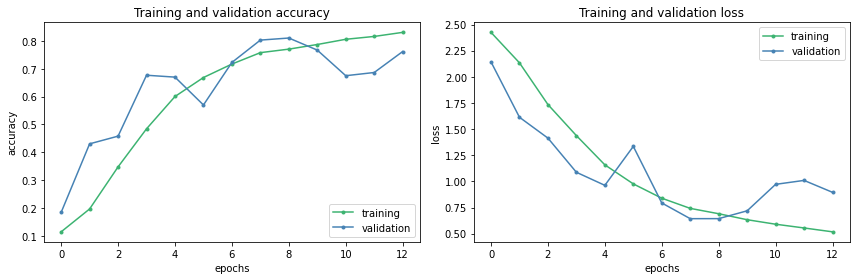

4703/4703 [==============================] - 4s 876us/step
Score Accuracy:  0.8026791409738465
Score Log Loss:  0.6432790515262814
              precision    recall  f1-score   support

          c0       0.83      0.47      0.60       455
          c1       0.87      0.77      0.82       466
          c2       0.84      0.89      0.86       515
          c3       0.92      0.92      0.92       487
          c4       0.67      0.94      0.79       500
          c5       1.00      0.87      0.93       498
          c6       0.89      0.78      0.83       483
          c7       0.87      0.96      0.91       425
          c8       0.62      0.71      0.66       416
          c9       0.63      0.68      0.66       458

    accuracy                           0.80      4703
   macro avg       0.81      0.80      0.80      4703
weighted avg       0.82      0.80      0.80      4703



Fold 2 out of 5
Model: "sequential_2"
_________________________________________________________________
Laye

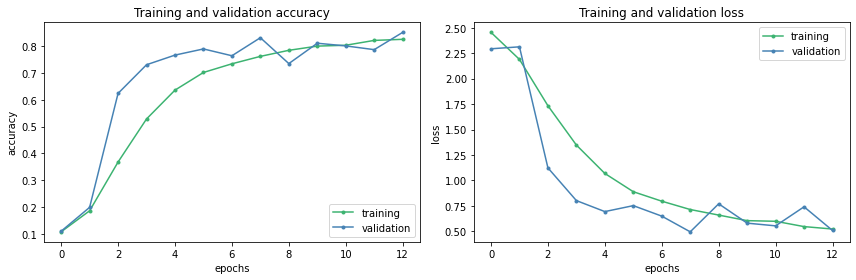

5303/5303 [==============================] - 5s 875us/step
Score Accuracy:  0.8321704695455403
Score Log Loss:  0.4955834480076227
              precision    recall  f1-score   support

          c0       0.77      0.85      0.81       637
          c1       0.76      0.79      0.77       534
          c2       0.98      0.69      0.81       518
          c3       0.95      0.92      0.93       554
          c4       0.88      0.99      0.94       529
          c5       1.00      0.84      0.91       534
          c6       0.79      0.94      0.86       541
          c7       0.97      1.00      0.98       459
          c8       0.65      0.77      0.71       440
          c9       0.65      0.55      0.60       557

    accuracy                           0.83      5303
   macro avg       0.84      0.83      0.83      5303
weighted avg       0.84      0.83      0.83      5303



Fold 3 out of 5
Model: "sequential_3"
_________________________________________________________________
Laye

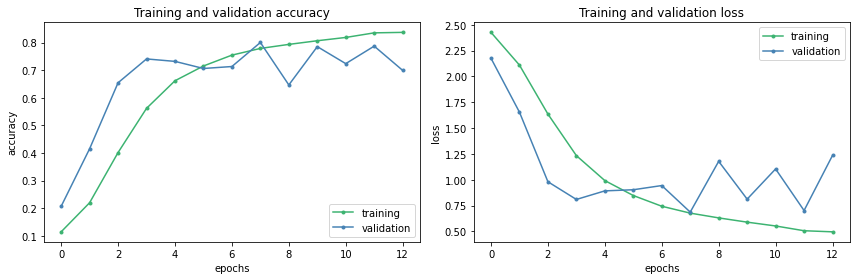

3932/3932 [==============================] - 4s 900us/step
Score Accuracy:  0.8001017293997965
Score Log Loss:  0.6865994803941416
              precision    recall  f1-score   support

          c0       0.83      0.66      0.73       419
          c1       0.79      0.92      0.85       409
          c2       0.82      0.97      0.89       409
          c3       1.00      0.68      0.81       410
          c4       0.99      0.77      0.87       413
          c5       1.00      0.97      0.98       414
          c6       0.89      0.79      0.84       416
          c7       0.75      0.98      0.85       378
          c8       0.52      0.58      0.55       317
          c9       0.51      0.61      0.56       347

    accuracy                           0.80      3932
   macro avg       0.81      0.79      0.79      3932
weighted avg       0.82      0.80      0.80      3932



Fold 4 out of 5
Model: "sequential_4"
_________________________________________________________________
Laye

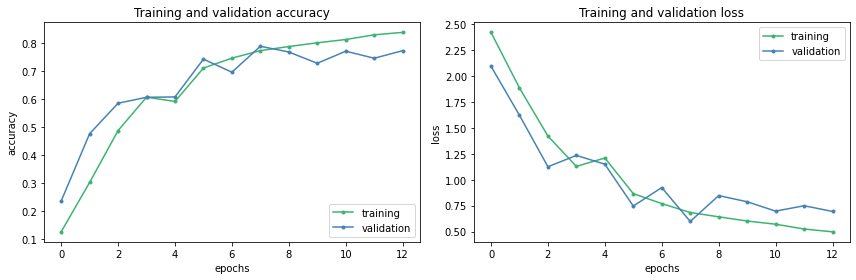

4310/4310 [==============================] - 4s 913us/step
Score Accuracy:  0.7879350348027843
Score Log Loss:  0.5976327016503957
              precision    recall  f1-score   support

          c0       0.81      0.65      0.72       501
          c1       0.83      0.82      0.83       408
          c2       0.73      0.85      0.79       429
          c3       0.82      0.99      0.90       459
          c4       0.94      0.89      0.92       437
          c5       0.99      0.79      0.88       452
          c6       0.95      0.85      0.90       435
          c7       0.74      0.85      0.79       402
          c8       0.71      0.64      0.67       376
          c9       0.44      0.54      0.49       411

    accuracy                           0.79      4310
   macro avg       0.80      0.79      0.79      4310
weighted avg       0.80      0.79      0.79      4310



Fold 5 out of 5
Model: "sequential_5"
_________________________________________________________________
Laye

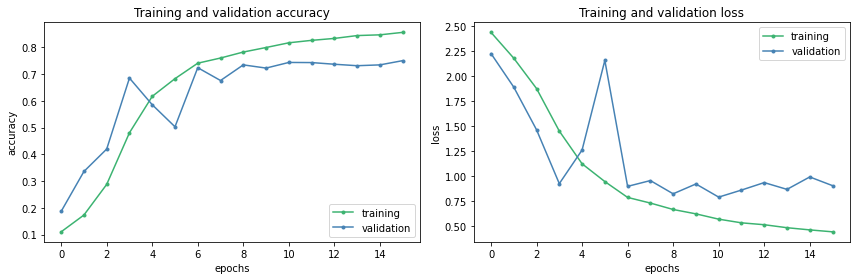

4176/4176 [==============================] - 4s 938us/step
Score Accuracy:  0.7432950191570882
Score Log Loss:  0.7885676503473628
              precision    recall  f1-score   support

          c0       0.72      0.73      0.73       477
          c1       1.00      0.48      0.65       450
          c2       0.74      0.98      0.84       446
          c3       0.96      0.87      0.91       436
          c4       0.75      0.84      0.79       447
          c5       0.95      0.97      0.96       414
          c6       0.67      0.75      0.70       450
          c7       0.91      0.72      0.81       338
          c8       0.49      0.57      0.53       362
          c9       0.42      0.43      0.43       356

    accuracy                           0.74      4176
   macro avg       0.76      0.74      0.74      4176
weighted avg       0.77      0.74      0.74      4176

Avg Accuracy train indipendent:  0.7953085979307885
Avg Log Loss train indipendent:  0.6342305125305959


,k,accuracy,log_loss,architecture,weighted_mean_loss,weighted_mean_acc
0,1,0.802679,0.643279,vgg16_4,0.634231,0.795309
1,2,0.832170,0.495583,vgg16_4,0.634231,0.795309
2,3,0.800102,0.686599,vgg16_4,0.634231,0.795309
3,4,0.787935,0.597633,vgg16_4,0.634231,0.795309
4,5,0.743295,0.788568,vgg16_4,0.634231,0.795309


In [0]:
training_model(128,128,3, final_layer=4)

### VGG16_trainable_2
It refers to the architecture where the last two blocks of VGG16 and the extra_layers are trained together



Fold 1 out of 5




58892288/58889256 [==============================] - 1s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
___________________________________________

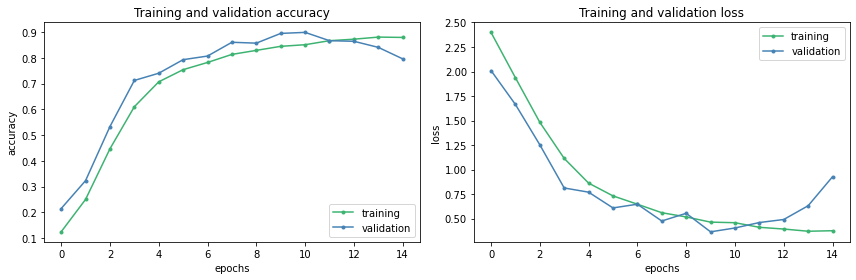

4703/4703 [==============================] - 14s 3ms/step
Score Accuracy:  0.8953859238783755
Score Log Loss:  0.3642382953568508
              precision    recall  f1-score   support

          c0       0.82      0.60      0.69       455
          c1       0.91      0.95      0.93       466
          c2       0.90      0.98      0.94       515
          c3       0.95      0.94      0.95       487
          c4       0.91      0.96      0.94       500
          c5       0.99      0.97      0.98       498
          c6       0.93      1.00      0.96       483
          c7       1.00      0.98      0.99       425
          c8       0.89      0.70      0.79       416
          c9       0.66      0.82      0.73       458

    accuracy                           0.90      4703
   macro avg       0.90      0.89      0.89      4703
weighted avg       0.90      0.90      0.89      4703



Fold 2 out of 5
Model: "sequential_2"
_________________________________________________________________
Layer

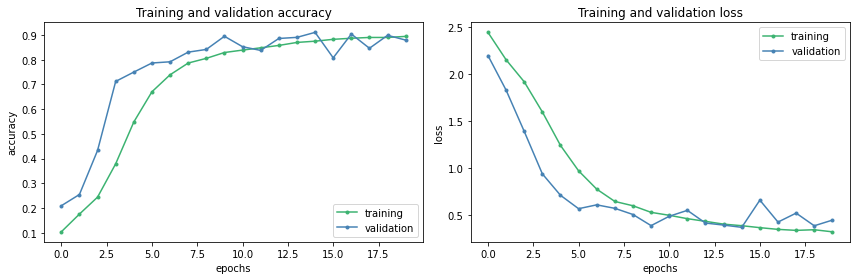

5303/5303 [==============================] - 16s 3ms/step
Score Accuracy:  0.9106166320950405
Score Log Loss:  0.36996466642934034
              precision    recall  f1-score   support

          c0       0.70      0.89      0.78       637
          c1       0.99      0.94      0.97       534
          c2       0.94      0.97      0.96       518
          c3       0.91      1.00      0.95       554
          c4       0.97      1.00      0.98       529
          c5       1.00      0.98      0.99       534
          c6       0.92      0.96      0.94       541
          c7       1.00      0.98      0.99       459
          c8       0.92      0.85      0.88       440
          c9       0.89      0.55      0.68       557

    accuracy                           0.91      5303
   macro avg       0.92      0.91      0.91      5303
weighted avg       0.92      0.91      0.91      5303



Fold 3 out of 5
Model: "sequential_3"
_________________________________________________________________
Laye

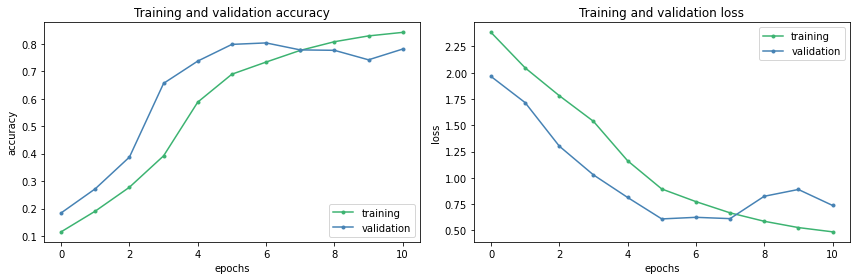

3932/3932 [==============================] - 12s 3ms/step
Score Accuracy:  0.7980671414038657
Score Log Loss:  0.609635367616589
              precision    recall  f1-score   support

          c0       0.70      0.66      0.68       419
          c1       0.80      0.87      0.83       409
          c2       0.72      0.95      0.82       409
          c3       1.00      0.81      0.89       410
          c4       0.91      0.97      0.94       413
          c5       0.99      1.00      0.99       414
          c6       0.68      0.92      0.78       416
          c7       0.89      0.88      0.88       378
          c8       0.45      0.09      0.14       317
          c9       0.63      0.67      0.65       347

    accuracy                           0.80      3932
   macro avg       0.78      0.78      0.76      3932
weighted avg       0.79      0.80      0.78      3932



Fold 4 out of 5
Model: "sequential_4"
_________________________________________________________________
Layer 

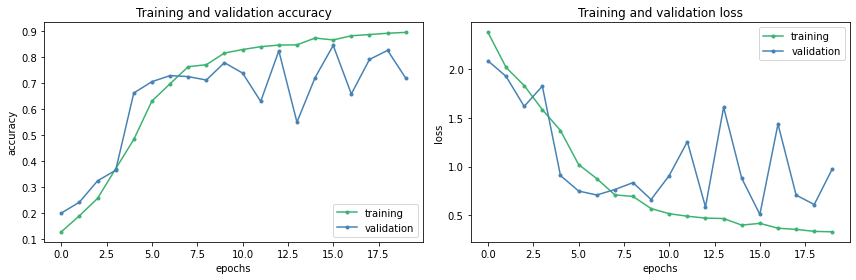

4310/4310 [==============================] - 13s 3ms/step
Score Accuracy:  0.8438515081206497
Score Log Loss:  0.5087057268975461
              precision    recall  f1-score   support

          c0       0.93      0.55      0.69       501
          c1       0.93      0.95      0.94       408
          c2       0.94      0.76      0.84       429
          c3       0.93      0.99      0.96       459
          c4       0.96      0.88      0.92       437
          c5       0.98      0.91      0.94       452
          c6       0.95      0.91      0.93       435
          c7       0.94      0.96      0.95       402
          c8       0.55      0.88      0.68       376
          c9       0.56      0.70      0.62       411

    accuracy                           0.84      4310
   macro avg       0.87      0.85      0.85      4310
weighted avg       0.87      0.84      0.85      4310



Fold 5 out of 5
Model: "sequential_5"
_________________________________________________________________
Layer

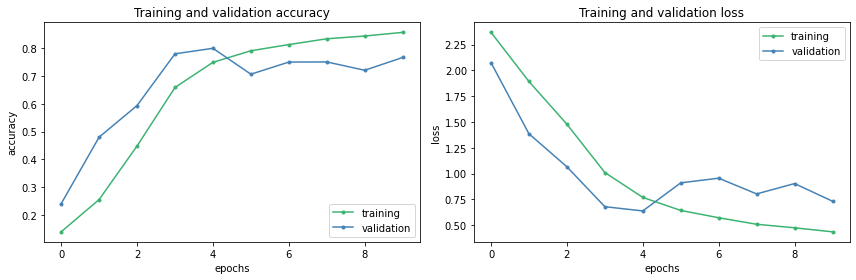

4176/4176 [==============================] - 13s 3ms/step
Score Accuracy:  0.7995689655172413
Score Log Loss:  0.6385062887035516
              precision    recall  f1-score   support

          c0       0.89      0.70      0.78       477
          c1       0.99      0.73      0.84       450
          c2       0.99      0.66      0.79       446
          c3       0.96      0.94      0.95       436
          c4       0.99      0.78      0.87       447
          c5       0.86      0.99      0.92       414
          c6       0.79      0.84      0.82       450
          c7       0.81      0.94      0.87       338
          c8       0.45      0.76      0.56       362
          c9       0.56      0.69      0.62       356

    accuracy                           0.80      4176
   macro avg       0.83      0.80      0.80      4176
weighted avg       0.84      0.80      0.81      4176

Avg Accuracy train indipendent:  0.8541740991794506
Avg Log Loss train indipendent:  0.4874663547610125


,k,accuracy,log_loss,architecture,weighted_mean_loss,weighted_mean_acc
0,1,0.895386,0.364238,vgg16_8,0.487466,0.854174
1,2,0.910617,0.369965,vgg16_8,0.487466,0.854174
2,3,0.798067,0.609635,vgg16_8,0.487466,0.854174
3,4,0.843852,0.508706,vgg16_8,0.487466,0.854174
4,5,0.799569,0.638506,vgg16_8,0.487466,0.854174


In [0]:
training_model(128,128,3, final_layer=8)